Columnas disponibles: ['ano', 'mes', 'dia', 'municipio', 'estacion', 'so2', 'co', 'no', 'no2', 'pm2.5', 'pm10', 'nox', 'o3', 'tol', 'ben', 'ebe']
Estaciones únicas: [np.int64(4), np.int64(8), np.int64(11), np.int64(16), np.int64(17), np.int64(18), np.int64(24), np.int64(27), np.int64(35), np.int64(36), np.int64(38), np.int64(39), np.int64(40), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60)]


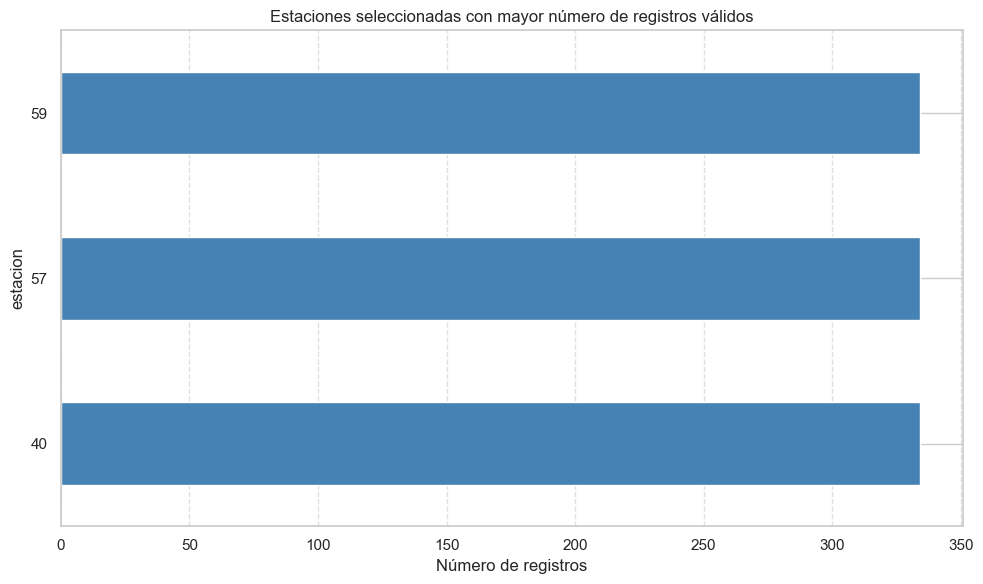

In [1]:
# -------------------------------
# Importaciones generales
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
)


sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 100# -------------------------------
# -------------------------------
# Carga y limpieza inicial
# -------------------------------

# Cargar el dataset
df = pd.read_csv("act2_estaciones_madrid.csv", sep=",", encoding="utf-8")

# Normalizar nombres de columnas
df.columns = df.columns.str.strip().str.lower() \
    .str.replace('á', 'a').str.replace('é', 'e') \
    .str.replace('í', 'i').str.replace('ó', 'o') \
    .str.replace('ú', 'u')

# Confirmar estructura
print("Columnas disponibles:", df.columns.tolist())
print("Estaciones únicas:", sorted(df['estacion'].unique()))








# Cargar el dataset
df = pd.read_csv("act2_estaciones_madrid.csv", sep=",", encoding="utf-8")

# Normalizar nombres de columnas
df.columns = df.columns.str.strip().str.lower() \
    .str.replace('á', 'a').str.replace('é', 'e') \
    .str.replace('í', 'i').str.replace('ó', 'o') \
    .str.replace('ú', 'u')

# Filtrar las estaciones seleccionadas
df_filtrado = df[df['estacion'].isin([40, 57, 59])].copy()

# Eliminar registros con nulos en variables clave
df_filtrado = df_filtrado.dropna(subset=['no2', 'nox', 'no'])

# Contar registros por estación (ordenado de menor a mayor)
conteo_estaciones = df_filtrado['estacion'].value_counts().sort_values(ascending=True)

# Crear gráfico de barras horizontal
plt.figure(figsize=(10, 6))
conteo_estaciones.plot(kind='barh', color='steelblue')
plt.xlabel("Número de registros")
plt.title("Estaciones seleccionadas con mayor número de registros válidos")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [7]:
# -------------------------------
# Filtrado y limpieza parcial
# -------------------------------


estaciones_objetivo = [40, 57, 59]

# Filtrado
df_filtrado = df[df['estacion'].isin(estaciones_objetivo)].copy()

# Eliminamos solo nulos
variables_filtrables = ['no2', 'nox', 'no']
df_filtrado = df_filtrado.dropna(subset=variables_filtrables)


print(f"Registros tras limpieza: {len(df_filtrado)}")
print("Estaciones incluidas:", df_filtrado['estacion'].unique())

df_filtrado.head()


Registros tras limpieza: 1002
Estaciones incluidas: [40 57 59]


,ano,mes,dia,municipio,estacion,so2,co,no,no2,pm2.5,pm10,nox,o3,tol,ben,ebe
12,2021,1,1,79,40,NaN,NaN,4.0,17.0,NaN,6.0,23.0,NaN,NaN,NaN,NaN
20,2021,1,1,79,57,2.0,NaN,1.0,15.0,3.0,4.0,17.0,NaN,NaN,NaN,NaN
22,2021,1,1,79,59,NaN,NaN,1.0,7.0,NaN,NaN,9.0,48.0,NaN,NaN,NaN
36,2021,1,2,79,40,NaN,NaN,8.0,27.0,NaN,6.0,39.0,NaN,NaN,NaN,NaN
44,2021,1,2,79,57,2.0,NaN,5.0,23.0,2.0,4.0,30.0,NaN,NaN,NaN,NaN


In [9]:
# -------------------------------
# Discretización de NO2
# -------------------------------

from sklearn.preprocessing import KBinsDiscretizer


df_modelo = df_filtrado.copy()

# Inicializamos el discretizador: 3 clases, cuantiles
discretizador = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

# Aplicamos la transformación y la guardamos como nueva columna 'no2_clase'
df_modelo['no2_clase'] = discretizador.fit_transform(df_modelo[['no2']]).astype(int)

# Verificamos distribución de clases
print("Distribución de clases (0: bajo, 1: medio, 2: alto):")
print(df_modelo['no2_clase'].value_counts().sort_index())


df_modelo[['no2', 'no2_clase']].head()


Distribución de clases (0: bajo, 1: medio, 2: alto):
no2_clase
0    314
1    352
2    336
Name: count, dtype: int64


,no2,no2_clase
12,17.0,1
20,15.0,0
22,7.0,0
36,27.0,2
44,23.0,1


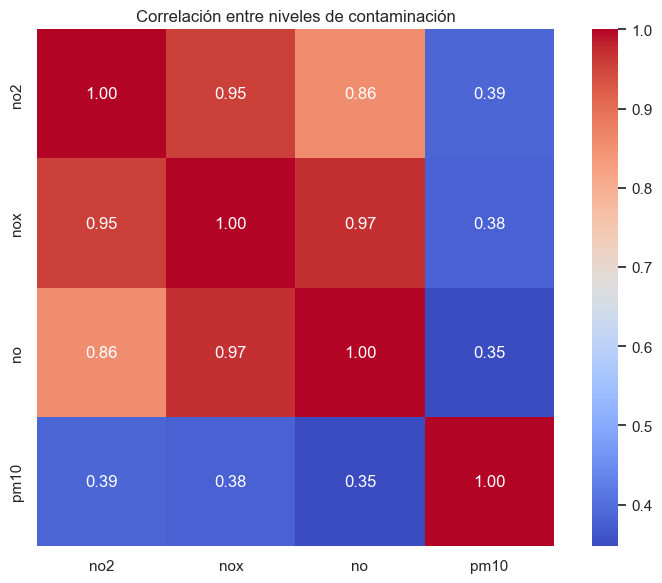

In [2]:
# -------------------------------
# Análisis de correlación
# -------------------------------

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import pandas as pd

# Variables válidas (sin 'co')
variables_corr_validas = ['no2', 'nox', 'no', 'pm10']
df_corr = df_filtrado[variables_corr_validas].copy()

# Imputación de valores nulos con la media
imputador = SimpleImputer(strategy='mean')
df_corr_imputado = pd.DataFrame(imputador.fit_transform(df_corr), columns=variables_corr_validas)

#matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr_imputado.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlación entre niveles de contaminación")
plt.tight_layout()
plt.show()



In [11]:
# -------------------------------
# División de datos y primer modelo
# -------------------------------

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


X = df_modelo[['no', 'pm10', 'co']]  
y = df_modelo['no2_clase']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


modelo_arbol = DecisionTreeClassifier(random_state=42)
modelo_arbol.fit(X_train, y_train)

# Evaluación del modelo
y_pred = modelo_arbol.predict(X_test)
print("Reporte de clasificación (Árbol de Decisión):")
print(classification_report(y_test, y_pred))


Reporte de clasificación (Árbol de Decisión):
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        63
           1       0.69      0.61      0.65        71
           2       0.83      0.82      0.83        67

    accuracy                           0.76       201
   macro avg       0.76      0.76      0.76       201
weighted avg       0.75      0.76      0.75       201



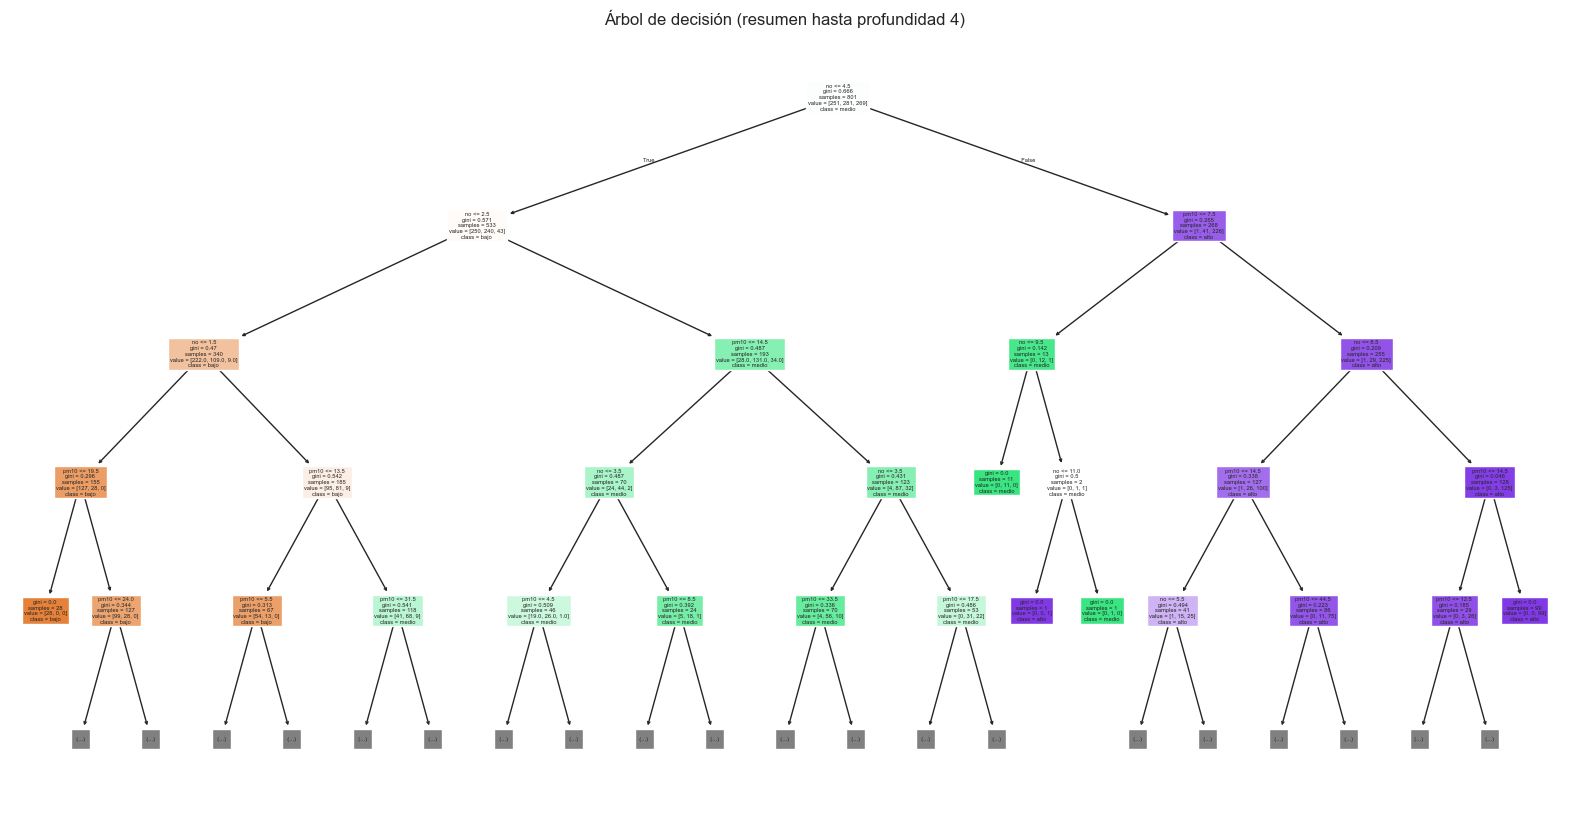

In [23]:
# -------------------------------
# Visualización clara del árbol
# -------------------------------
plt.figure(figsize=(20, 10))  

plot_tree(
    modelo_arbol,
    feature_names=['no', 'pm10', 'co'],
    class_names=["bajo", "medio", "alto"],
    filled=True,
    max_depth=4  
)

plt.title("Árbol de decisión")
plt.show()




Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros encontrados:
{'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}

Informe de clasificación con los mejores parámetros:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78        63
           1       0.70      0.65      0.67        71
           2       0.85      0.85      0.85        67

    accuracy                           0.77       201
   macro avg       0.77      0.77      0.77       201
weighted avg       0.76      0.77      0.76       201



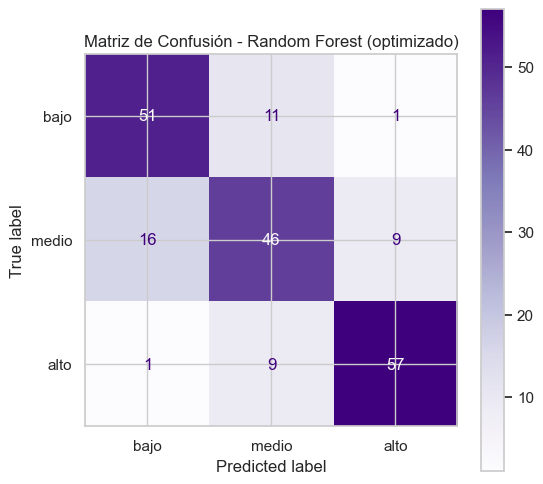

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Definir la rejilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Inicializar el clasificador base
rf_base = RandomForestClassifier(random_state=42)

# Inicializar el GridSearchCV 
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,                  
    scoring='f1_macro',    
    n_jobs=-1,             
    verbose=1              
)

# Entrenar el modelo
grid_search.fit(X2_train, y2_train)

# Mostrar
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)


mejor_modelo = grid_search.best_estimator_
y_pred_gs = mejor_modelo.predict(X2_test)

print("\nInforme de clasificación con los mejores parámetros:")
print(classification_report(y2_test, y_pred_gs))

# Matriz de confusión
cm_gs = confusion_matrix(y2_test, y_pred_gs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gs, display_labels=["bajo", "medio", "alto"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Purples', values_format='d')
plt.title("Matriz de Confusión - Random Forest")
plt.show()



